# DAML Project 3: Geant4

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Step 1 - Geant4 Simulation

I created a simple particle detector simulation in Geant 4. My detector is comprised of two cylindrical tracking layers, at 400 cm and 800 cm radii from the beam line, and an outer calorimeter cylinder at a radius of 900 cm from the beam. The calorimeter has 5 liquid argon cells separated by lead shielding. 

My simulation of 1000 events yielded 4 datasets: Layer_total, Energy, Tracker1_hits, and Tracker2_hits. These datasets are read as pandas dataframes below. 

In [24]:
# reading data csvs as dataframes
Layer_total = pd.read_csv('output_h1_LayerTotal.csv', comment='#')
Energy = pd.read_csv('output_nt_Energy.csv', comment='#', names=['Double_generated', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5'])
Tracker1_hits = pd.read_csv('output_nt_Tracker1.csv', comment='#', names=['Event', 'Phi', 'Theta'])
Tracker2_hits = pd.read_csv('output_nt_Tracker2.csv', comment='#', names=['Event', 'Phi', 'Theta'])

In [64]:
Layer_total.head()

,entries,Sw,Sw2,Sxw0,Sx2w0
0,0,0.00,0.0,0.00,0.00
1,1000,2822.65,127061.0,2822.65,2822.65
2,1000,2945.30,98679.7,5890.60,11781.20
3,1000,3093.51,104631.0,9280.54,27841.60
4,1000,2839.33,104088.0,11357.30,45429.20


In [25]:
Energy.head()

,Double_generated,Layer1,Layer2,Layer3,Layer4,Layer5
0,0,0.0,0.0,0.0000,0.0,0.0000
1,0,0.0,0.0,33.9626,0.0,0.0000
2,0,0.0,0.0,0.0000,0.0,0.0000
3,0,0.0,0.0,0.0000,0.0,0.0000
4,0,0.0,0.0,0.0000,0.0,34.3463


In [19]:
Tracker1_hits.head()

,Event,Phi,Theta
0,1,-1.648820,1.60378
1,4,0.111076,0.92474
2,5,-0.007242,1.46939
3,6,0.860503,2.14303
4,6,0.860503,2.14303


In [21]:
Tracker2_hits.head()

,Event,Phi,Theta
0,1,-1.647600,1.601240
1,4,0.103150,0.921112
2,4,0.103149,0.921112
3,4,0.103148,0.921112
4,5,-0.009923,1.471130


In [29]:
print('Dataframe lengths:', len(Layer_total.index), ',', len(Energy.index), ',', len(Tracker1_hits.index), ',', len(Tracker2_hits.index))

Dataframe lengths: 7 , 1000 , 1030 , 1188


The tracker hits are expected to be more than the number of events (1000), as they can be hit multiple times per event. 

## Step 2 - Data Reconstruction

The detector should be able to measure the energy or momentum of particles and distinguish between two types of particle. For each input particle, I will produce an energy or momentum measurement and indicate what type of particle it is. 

### Isolating Particle Tracks

If entries with the same Event ID have the same (or very similar) theta values, they are considered to be the same particle.

In [113]:
# initializing empty lists for things I want to record
event_ids = []
t1_indices = []
t2_indices = []
t1_thetas = []
t2_thetas = []
t1_phis = []
t2_phis = []

events = np.arange(1000)

# looping through event IDs 1 to 1000, recording all of the information of
# reconstructed particles that meet the requirement of having a delta theta
# value less than 0.00004. I record the event ID, the indices of the particle
# in both tracker datasets, and the theta angles of the particle in both 
# datasets
for event in events:
    # decreasing the datasets to subsets by event ID reduces loop time significantly
    subset1 = Tracker1_hits[Tracker1_hits['Event'] == event]
    subset2 = Tracker2_hits[Tracker2_hits['Event'] == event]
    
    for ind1 in subset1.index:
        for ind2 in subset2.index:
            if abs(subset1['Theta'][ind1] - subset2['Theta'][ind2]) < 0.0001:
                event_ids.append(event)
                t1_indices.append(ind1)
                t2_indices.append(ind2)
                t1_thetas.append(subset1['Theta'][ind1])
                t2_thetas.append(subset2['Theta'][ind2])
                t1_phis.append(subset1['Phi'][ind1])
                t2_phis.append(subset2['Phi'][ind2])

# compiling the reconstructed particle information in a dataframe
pairs = pd.DataFrame({'EventID': event_ids, 
                      't1_index': t1_indices,
                      't2_index': t2_indices,
                      't1_theta': t1_thetas,
                      't2_theta': t2_thetas,
                      't1_phi': t1_phis,
                      't2_phi': t2_phis
                     })

In [114]:
pairs.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi
0,101,104,112,1.64051,1.64045,2.343200,2.340280
1,267,293,277,2.20572,2.20578,1.508710,1.509310
2,267,294,277,2.20572,2.20578,1.508710,1.509310
3,267,295,277,2.20572,2.20578,1.508710,1.509310
4,504,505,543,1.06251,1.06247,-0.293562,-0.290597


### Calculating Momentum

In [115]:
def calc_sagitta(phi1, phi2, r1):
    # a function to calculate sagitta
    # phi1 is the phi value in the first tracker
    # phi2 is the phi value in the second tracker
    # r1 is the radius of layer 1 in meters
    delta_phi = abs(phi1 - phi2)
    sagitta = np.sin(delta_phi)*r1
    return sagitta

def calc_momentum(r2, sagitta, B, theta):
    # a function to calculate total momentum
    # r2 is the radius of layer 2 in meters
    # B is the value of the magnetic field
    # theta is the theta value of the reconstructed
    # track, which should be the same for both trackers
    R = (r2**2) / (8*sagitta)
    p_T = 0.3*B*R
    p = p_T / np.sin(theta)
    return p

In [116]:
R2 = 8  # radius of second tracker, in meters
R1 = 4  # radius of first tracker, in meters
B = 0  # value of magnetic field

# initializing an empty list to record calculated momenta
calculated_momenta = []

# looping through every reconstructed particle in the pairs dataframe, using the functions
# in the previous cell to calculate total momentum. I chose just to use the theta value
# in the tracker1 dataset, since it is essentially equal to the theta in tracker2 data
for item in pairs.index:
    index_1 = pairs['t1_index'][item]
    index_2 = pairs['t2_index'][item]
    
    s = calc_sagitta(Tracker1_hits['Phi'][index_1], Tracker2_hits['Phi'][index_2], R1)
    p = calc_momentum(R2, s, B, pairs['t1_theta'][item])
    
    calculated_momenta.append(p)

# concatenating the momentum data and the pairs dataframe
momenta_df = pd.DataFrame({'momentum': calculated_momenta})
pairs = pd.concat([pairs, momenta_df], axis=1)

In [117]:
pairs.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum
0,101,104,112,1.64051,1.64045,2.343200,2.340280,0.0
1,267,293,277,2.20572,2.20578,1.508710,1.509310,0.0
2,267,294,277,2.20572,2.20578,1.508710,1.509310,0.0
3,267,295,277,2.20572,2.20578,1.508710,1.509310,0.0
4,504,505,543,1.06251,1.06247,-0.293562,-0.290597,0.0


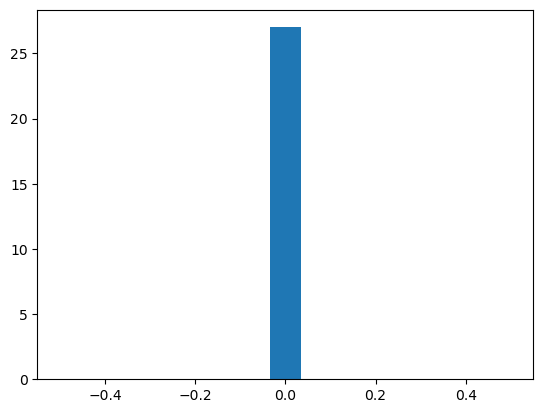

In [118]:
plt.figure()
plt.hist(pairs['momentum'], bins=15)
plt.show()

### Classifying Particles

A magnetic field is applied to the detector, causing charged particles to curve as they leave the collision point. Uncharged particles are unaffected by the field. The variable that would be impacted by a magnetic field is the phi value, so using the tracker data, I can differentiate between charged particles (electrons) and uncharged particles (photons) by looking at how their phi values change between tracker measurements. 

In [119]:
# using a similar method to how I determined whether particles were 'pairs' or not
photon_indices = []
electron_indices = []

for index, row in pairs.iterrows():
    phi_diff = abs(row['t1_phi'] - row['t2_phi'])
    
    if phi_diff < 0.01:
        photon_indices.append(index)
    else:
        electron_indices.append(index)


# saving these values in separate dataframes:
photons = pairs.loc[photon_indices]
electrons = pairs.loc[electron_indices]

In [120]:
photons.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum
0,101,104,112,1.64051,1.64045,2.343200,2.340280,0.0
1,267,293,277,2.20572,2.20578,1.508710,1.509310,0.0
2,267,294,277,2.20572,2.20578,1.508710,1.509310,0.0
3,267,295,277,2.20572,2.20578,1.508710,1.509310,0.0
4,504,505,543,1.06251,1.06247,-0.293562,-0.290597,0.0


In [121]:
electrons.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum


In [122]:
print('There are', len(photons.index), 'photons and', len(electrons.index), 'electrons.')

There are 27 photons and 0 electrons.


### Dataset for B = 0.2 T, p = 500 MeV/c [E = 300 MeV]

In [222]:
Layer_total_2 = pd.read_csv('output_h1_LayerTotal_B0.2.csv', comment='#')
Energy_2 = pd.read_csv('output_nt_Energy_B0.2.csv', comment='#', names=['Momentum', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5'])
Tracker1_hits_2 = pd.read_csv('output_nt_Tracker1_B0.2.csv', comment='#', names=['Event', 'Phi', 'Theta'])
Tracker2_hits_2 = pd.read_csv('output_nt_Tracker2_B0.2.csv', comment='#', names=['Event', 'Phi', 'Theta'])

In [223]:
# initializing empty lists for things I want to record
event_ids = []
t1_indices = []
t2_indices = []
t1_thetas = []
t2_thetas = []
t1_phis = []
t2_phis = []

events = np.arange(1000)

# looping through event IDs 1 to 1000, recording all of the information of
# reconstructed particles that meet the requirement of having a delta theta
# value less than 0.00004. I record the event ID, the indices of the particle
# in both tracker datasets, and the theta angles of the particle in both 
# datasets
for event in events:
    # decreasing the datasets to subsets by event ID reduces loop time significantly
    subset1 = Tracker1_hits_2[Tracker1_hits_2['Event'] == event]
    subset2 = Tracker2_hits_2[Tracker2_hits_2['Event'] == event]
    
    for ind1 in subset1.index:
        for ind2 in subset2.index:
            if abs(subset1['Theta'][ind1] - subset2['Theta'][ind2]) < 0.001:
                event_ids.append(event)
                t1_indices.append(ind1)
                t2_indices.append(ind2)
                t1_thetas.append(subset1['Theta'][ind1])
                t2_thetas.append(subset2['Theta'][ind2])
                t1_phis.append(subset1['Phi'][ind1])
                t2_phis.append(subset2['Phi'][ind2])

# compiling the reconstructed particle information in a dataframe
pairs_2 = pd.DataFrame({'EventID': event_ids, 
                      't1_index': t1_indices,
                      't2_index': t2_indices,
                      't1_theta': t1_thetas,
                      't2_theta': t2_thetas,
                      't1_phi': t1_phis,
                      't2_phi': t2_phis
                     })

In [224]:
pairs_2.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi
0,133,266,493,1.54118,1.54204,-0.970110,-0.758616
1,133,267,493,1.54118,1.54204,-0.969926,-0.758616
2,268,446,830,1.56660,1.56593,0.218875,0.731233
3,698,1122,2452,1.77588,1.77526,-2.061640,-1.415880
4,777,1268,2697,1.59490,1.59488,2.722400,-3.043740


In [225]:
R2 = 8  # radius of second tracker, in meters
R1 = 4  # radius of first tracker, in meters
B = 0.2  # value of magnetic field

# initializing an empty list to record calculated momenta
calculated_momenta = []

# looping through every reconstructed particle in the pairs dataframe, using the functions
# in the previous cell to calculate total momentum. I chose just to use the theta value
# in the tracker1 dataset, since it is essentially equal to the theta in tracker2 data
for item in pairs_2.index:
    index_1 = pairs_2['t1_index'][item]
    index_2 = pairs_2['t2_index'][item]
    
    s = calc_sagitta(Tracker1_hits_2['Phi'][index_1], Tracker2_hits_2['Phi'][index_2], R1)
    p = calc_momentum(R2, s, B, pairs_2['t1_theta'][item])*1000 # multiplying by 1000 to convert to MeV
    
    calculated_momenta.append(p)

# concatenating the momentum data and the pairs dataframe
momenta_df = pd.DataFrame({'momentum': calculated_momenta})
pairs_2 = pd.concat([pairs_2, momenta_df], axis=1)

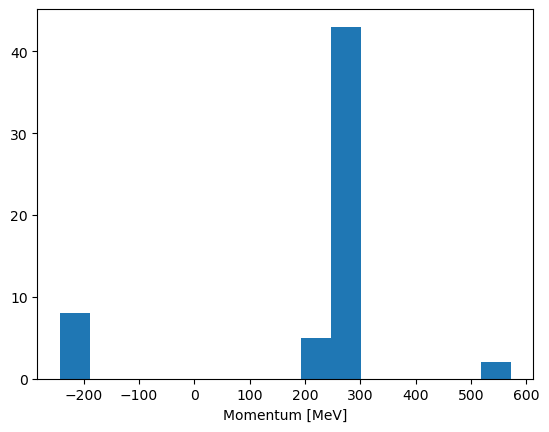

In [226]:
plt.figure()
plt.hist(pairs_2['momentum'], bins=15)
plt.xlabel('Momentum [MeV]')
plt.show()

In [165]:
# using a similar method to how I determined whether particles were 'pairs' or not
photon_indices = []
electron_indices = []

for index, row in pairs_2.iterrows():
    phi_diff = abs(row['t1_phi'] - row['t2_phi'])
    
    if phi_diff < 0.001:
        photon_indices.append(index)
    else:
        electron_indices.append(index)


# saving these values in separate dataframes:
photons_2 = pairs_2.loc[photon_indices]
electrons_2 = pairs_2.loc[electron_indices]

In [166]:
electrons_2.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum
0,133,266,493,1.54118,1.54204,-0.970110,-0.758616,571.894835
1,133,267,493,1.54118,1.54204,-0.969926,-0.758616,572.385373
2,268,446,830,1.56660,1.56593,0.218875,0.731233,244.783309
3,698,1122,2452,1.77588,1.77526,-2.061640,-1.415880,203.668023
4,777,1268,2697,1.59490,1.59488,2.722400,-3.043740,-242.831294


In [167]:
photons_2.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum


### Dataset for B = 3 T, p = 20 GeV/c [E = 0.3 GeV]

In [177]:
Layer_total_3 = pd.read_csv('output_h1_LayerTotal_B3_20GeV.csv', comment='#')
Energy_3 = pd.read_csv('output_nt_Energy_B3_20GeV.csv', comment='#', names=['Momentum', 'Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5'])
Tracker1_hits_3 = pd.read_csv('output_nt_Tracker1_B3_20GeV.csv', comment='#', names=['Event', 'Phi', 'Theta'])
Tracker2_hits_3 = pd.read_csv('output_nt_Tracker2_B3_20GeV.csv', comment='#', names=['Event', 'Phi', 'Theta'])

In [178]:
Energy_3.head()

,Momentum,Layer1,Layer2,Layer3,Layer4,Layer5
0,20000,0.0,0.000,0.000000,25.783000,0.0
1,20000,0.0,0.000,0.000000,0.000000,0.0
2,20000,1141.3,265.234,0.284993,0.657914,0.0
3,20000,0.0,0.000,0.000000,0.000000,0.0
4,20000,0.0,0.000,0.000000,0.000000,0.0


In [197]:
# initializing empty lists for things I want to record
event_ids = []
t1_indices = []
t2_indices = []
t1_thetas = []
t2_thetas = []
t1_phis = []
t2_phis = []

events = np.arange(1000)

# looping through event IDs 1 to 1000, recording all of the information of
# reconstructed particles that meet the requirement of having a delta theta
# value less than 0.00004. I record the event ID, the indices of the particle
# in both tracker datasets, and the theta angles of the particle in both 
# datasets
for event in events:
    # decreasing the datasets to subsets by event ID reduces loop time significantly
    subset1 = Tracker1_hits_3[Tracker1_hits_3['Event'] == event]
    subset2 = Tracker2_hits_3[Tracker2_hits_3['Event'] == event]
    
    for ind1 in subset1.index:
        for ind2 in subset2.index:
            if abs(subset1['Theta'][ind1] - subset2['Theta'][ind2]) < 0.001:
                event_ids.append(event)
                t1_indices.append(ind1)
                t2_indices.append(ind2)
                t1_thetas.append(subset1['Theta'][ind1])
                t2_thetas.append(subset2['Theta'][ind2])
                t1_phis.append(subset1['Phi'][ind1])
                t2_phis.append(subset2['Phi'][ind2])

# compiling the reconstructed particle information in a dataframe
pairs_3 = pd.DataFrame({'EventID': event_ids, 
                      't1_index': t1_indices,
                      't2_index': t2_indices,
                      't1_theta': t1_thetas,
                      't2_theta': t2_thetas,
                      't1_phi': t1_phis,
                      't2_phi': t2_phis
                     })

In [198]:
R2 = 8  # radius of second tracker, in meters
R1 = 4  # radius of first tracker, in meters
B = 0.2  # value of magnetic field

# initializing an empty list to record calculated momenta
calculated_momenta = []

# looping through every reconstructed particle in the pairs dataframe, using the functions
# in the previous cell to calculate total momentum. I chose just to use the theta value
# in the tracker1 dataset, since it is essentially equal to the theta in tracker2 data
for item in pairs_3.index:
    index_1 = pairs_3['t1_index'][item]
    index_2 = pairs_3['t2_index'][item]
    
    s = calc_sagitta(Tracker1_hits_3['Phi'][index_1], Tracker2_hits_3['Phi'][index_2], R1)
    p = calc_momentum(R2, s, B, pairs_3['t1_theta'][item])*10
    
    calculated_momenta.append(p)

# concatenating the momentum data and the pairs dataframe
momenta_df = pd.DataFrame({'momentum': calculated_momenta})
pairs_3 = pd.concat([pairs_3, momenta_df], axis=1)

In [199]:
pairs_3.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum
0,8,16,56,1.62138,1.62160,-1.902060,-1.811120,13.230642
1,9,21,62,1.87924,1.87921,1.955800,2.265090,4.137678
2,17,27,100,1.54704,1.54701,-0.860853,-0.770100,13.244609
3,17,27,101,1.54704,1.54701,-0.860853,-0.770066,13.239662
4,23,29,114,1.36630,1.36532,2.337110,2.429880,13.229446


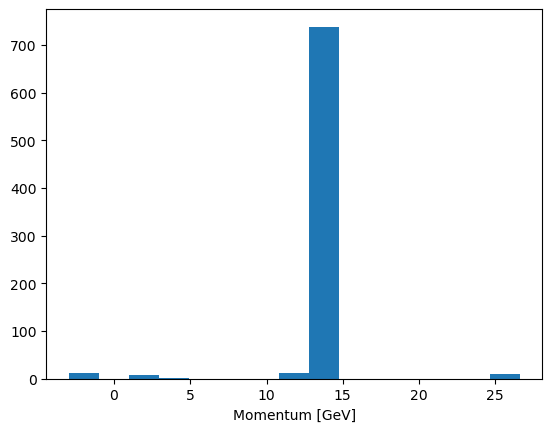

In [200]:
plt.figure()
plt.hist(pairs_3['momentum'], bins=15)
plt.xlabel('Momentum [GeV]')
plt.show()

In [201]:
# using a similar method to how I determined whether particles were 'pairs' or not
photon_indices = []
electron_indices = []

for index, row in pairs_3.iterrows():
    phi_diff = abs(row['t1_phi'] - row['t2_phi'])
    
    if phi_diff < 0.001:
        photon_indices.append(index)
    else:
        electron_indices.append(index)


# saving these values in separate dataframes:
photons_3 = pairs_3.loc[photon_indices]
electrons_3 = pairs_3.loc[electron_indices]

In [202]:
photons_3.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum


In [203]:
electrons_3.head()

,EventID,t1_index,t2_index,t1_theta,t2_theta,t1_phi,t2_phi,momentum
0,8,16,56,1.62138,1.62160,-1.902060,-1.811120,13.230642
1,9,21,62,1.87924,1.87921,1.955800,2.265090,4.137678
2,17,27,100,1.54704,1.54701,-0.860853,-0.770100,13.244609
3,17,27,101,1.54704,1.54701,-0.860853,-0.770066,13.239662
4,23,29,114,1.36630,1.36532,2.337110,2.429880,13.229446


## Step 3 - Data Validation

This section is dedicated to testing the results of the reconstruction by comparing them to the truth values. In step 3, I will calculatte my momentum resolution and the efficiency of my particle classification. I will also discuss whether these results vary over a range of input particle energies. 

In [206]:
def calc_resolution(column, actual_val):
    res_vals = []
    
    for value in column:
        diff = (value - actual_val)/actual_val
        res_vals.append(diff)
    return res_vals

def plot_resolution(res_vals, title='Momentum Resolution Distribution', bin_num=20):
    plt.figure()
    plt.hist(res_vals, bins=bin_num)
    plt.xlabel('(Calculated Momentum - True Momentum)/True Momentum')
    plt.ylabel('Number of Reconstructed Particles')
    plt.title(title)
    plt.show()

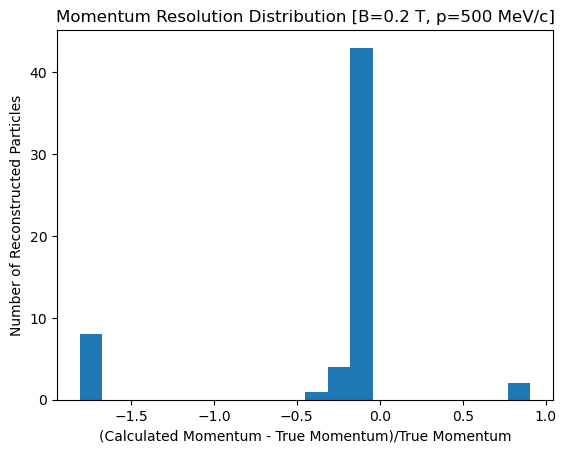

In [209]:
resolution_vals_2 = calc_resolution(pairs_2['momentum'], 300)
plot_resolution(resolution_vals_2, title='Momentum Resolution Distribution [B=0.2 T, p=500 MeV/c]')

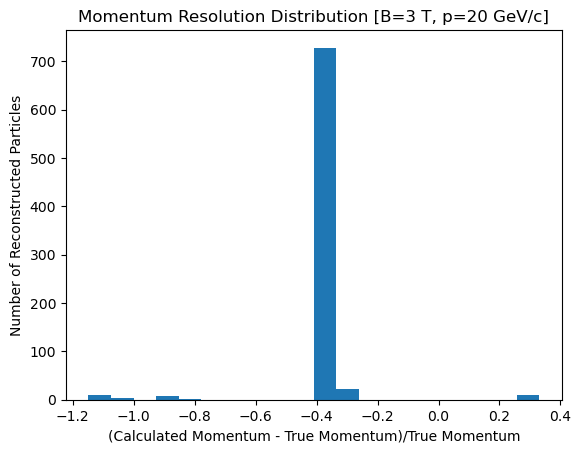

In [210]:
resolution_vals_3 = calc_resolution(pairs_3['momentum'], 20)
plot_resolution(resolution_vals_3, title='Momentum Resolution Distribution [B=3 T, p=20 GeV/c]')

### Particle Classification Efficiency



## Step 4 - Improvement and Discussion

This section aims to improve the resolution and/or classification of the data.

In [49]:
## TBD - Make classification neural networks for particle tracks (which are actually the same particle) and for electron/photon classification.

In [214]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import model_selection, preprocessing

In [ ]:
input_df = pairs_2[['t1_phi', 't2_phi', 'momentum']]
target_data = [1 for element in range(len(input_df.index))]

sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(input_df)

#set random seed
answer_to_everything = 42

#train-test-split the dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(\
                                                                                    input_data, target_data, test_size=0.3, \
                                                                                    random_state=answer_to_everything)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

In [ ]:
def my_model(num_inputs, num_nodes, extra_depth):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal',\
                    activation='relu'))
    model.add(Dropout(0.2))
    
    for i in range(extra_depth):
        model.add(Dense(num_nodes, kernel_initializer='normal'))
    
    model.add(Dense(1, kernel_initializer='normal'))       
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

In [ ]:
model = my_model(8, 20, 1)

history = model.fit(train_data, train_target, batch_size=500, epochs=50, verbose=1, \
                    validation_data=(test_data, test_target))

In [ ]:
epochs = np.arange(50)
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']

In [ ]:
model_4 = my_model(9, 20, 3)

history_4 = model_4.fit(train_data_2, train_target_2, batch_size=500, epochs=50, verbose=1, \
                        validation_data=(test_data_2, test_target_2))

In [ ]:
predicted = best_model.predict(train_data_2)

In [ ]:
def to_binary(input_array):
    binary_version = []
    
    for item in input_array:
        if item > 0.5:
            binary_version.append(1)
        else:
            binary_version.append(0)
    
    return binary_version

In [ ]:
predicted_binary = to_binary(predicted)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = train_target_2
y_pred = predicted_binary

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.title('Classifier Performance [Confusion Matrix]')
plt.show()